# Univariate Features Selection For b278 VVV Tile

- **author:** JB Cabral (<jbc.develop@gmail.com>)

In [2]:
% matplotlib inline

import numpy as np

import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

from sklearn import feature_selection as fs
from sklearn import preprocessing as prp

from skcriteria import Data, MAX, MIN
from skcriteria.madm import topsis, electre
from skcriteria.weights import critic

from libs import fourier_help

pd.options.mode.chained_assignment = None 

TWO_LABELS = {-1: -1, 1: 1, 2: 1, 3: 1}

## Load Data

In [3]:
df = pd.read_hdf("data/features.h5", "b278")
df["period_diff"] = np.abs(df.PeriodLS - df.gatspy_period)
df["cls"] = df["cls"].astype('category')
df["scls"] = df.apply(lambda r: TWO_LABELS[r["cls"]], axis=1).astype("category")

print len(df.columns) - 1

73


## 1. Removing Dumplicated and Dirty Data (nan and null)

In [4]:
# removing tff and gatspy
to_remove = (
    fourier_help.fourier_data(df.iloc[0], "kovacs").keys() + 
    ["gatspy_period"])
df = df[df.columns[~df.columns.isin(to_remove)]]

# columns with nan and null
df = df.loc[:, ~df.isnull().any()]

# sampling
# df = pd.concat([
#     df[df.cls == -1].sample(frac=.010),
#     df[df.cls != -1].sample(frac=.010)])

X_columns = df.columns[~df.columns.isin(["vvv_id", "cls", "scls"])]
X = prp.StandardScaler().fit_transform(df[X_columns].values)
y = df["scls"].values

df.sample(5)

,vvv_id,cls,Amplitude,Rcs,StetsonK,Meanvariance,Autocor_length,Con,Beyond1Std,SmallKurtosis,...,Freq2_harmonics_rel_phase_1,Freq2_harmonics_rel_phase_2,Freq2_harmonics_rel_phase_3,Freq3_harmonics_rel_phase_0,Freq3_harmonics_rel_phase_1,Freq3_harmonics_rel_phase_2,Freq3_harmonics_rel_phase_3,count,period_diff,scls
274833,4525247,-1,0.08300,0.396354,0.799539,0.002918,18.0,0.010638,0.312500,0.217096,...,-1.349799,0.543567,-0.797009,0.0,-1.760001,0.796585,0.680224,96,0.000007,-1
649073,3711043,-1,0.26850,0.392191,0.809429,0.008653,8.0,0.000000,0.363636,-0.117895,...,1.041172,1.038173,0.959396,0.0,0.117935,-1.874374,-2.269440,44,3.977788,-1
62064,3947535,-1,0.17850,0.410210,0.818404,0.005899,22.0,0.009091,0.330357,-0.470500,...,1.983506,0.585375,-1.010886,0.0,1.831156,-0.220114,0.932500,112,0.481254,-1
309699,4457844,-1,0.08625,0.363470,0.731338,0.002661,17.0,0.044643,0.236842,1.657109,...,-0.706520,-0.396047,-0.054454,0.0,1.537612,1.386387,1.456353,114,8.237377,-1
380668,4388869,-1,0.17600,0.369605,0.721950,0.006096,27.0,0.029586,0.222222,3.061838,...,-2.058240,-1.534451,-1.061088,0.0,-0.001027,1.062167,1.687553,171,0.833351,-1


##  2. Removes all low-variance features

In [5]:
vt = fs.VarianceThreshold()
vt.fit(X, y)

VarianceThreshold(threshold=0.0)

In [6]:
X_columns = X_columns[vt.get_support()]
X =  prp.StandardScaler().fit_transform(df[X_columns].values)
print(len(X_columns))

54


## 3. KBest With mutual_info

In [6]:
kbest_mutual_info = fs.SelectKBest(fs.mutual_info_classif, k="all")
%time kbest_mutual_info.fit(X, y)

CPU times: user 16min 4s, sys: 2.25 s, total: 16min 6s
Wall time: 16min 6s


SelectKBest(k='all',
      score_func=<function mutual_info_classif at 0x7f774812f398>)

## 4. KBest ANOVA

In [7]:
kbest_anova = fs.SelectKBest(fs.f_classif, k="all")
%time kbest_anova.fit(X, y)

CPU times: user 320 ms, sys: 72 ms, total: 392 ms
Wall time: 389 ms


SelectKBest(k='all', score_func=<function f_classif at 0x7f77493c7a28>)

## 5. KBest with $\chi^2$

In [8]:
kbest_chi2 = fs.SelectKBest(fs.chi2, k="all")
%time kbest_chi2.fit(X ** 2, y)

CPU times: user 280 ms, sys: 32 ms, total: 312 ms
Wall time: 346 ms


SelectKBest(k='all', score_func=<function chi2 at 0x7f77493c7b18>)

## 6. MCDM

### 6.1. Preprocess

In [9]:
result = pd.DataFrame(
    index=X_columns, data={
    "mutual_info_classif": kbest_mutual_info.scores_,
    "anova": kbest_anova.scores_,
    "chi2": kbest_chi2.scores_      
})

In [10]:
skc_data = Data(
    result.as_matrix(), [MAX, MAX, MAX], 
    anames=X_columns, cnames=result.columns.values)
w_skc_data = critic.CriticWeights().decide(skc_data)
w_skc_data

ALT./CRIT.,anova (max) W.0.258256511595,chi2 (max) W.0.24245550534,mutual_info_classif (max) W.0.499287983065
Amplitude,17.3091,242.202,0.000349454
Rcs,134.201,3.96089,0.000259842
StetsonK,148.219,10.045,0.000188712
Meanvariance,3.73469,322.286,0.000157657
Autocor_length,197.165,203.578,0.00540458
Con,0.377627,0.978778,0.0323973
Beyond1Std,30.2529,0.433427,0.000864605
SmallKurtosis,7.99736,5.56877,0.000147807
Std,8.60864,249.896,0.000190999
Skew,7.86039,43.1003,6.01768e-05


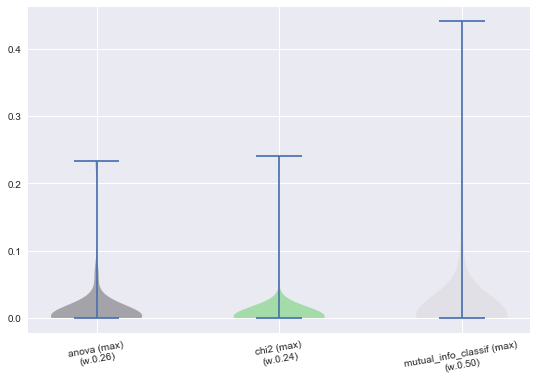

In [11]:
ax = w_skc_data.plot.violin(mnorm="vector", cmap="nipy_spectral", weighted=True)
plt.show()

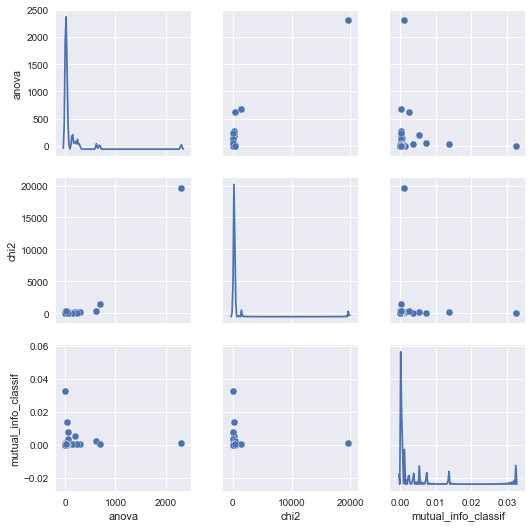

In [12]:
sns.pairplot(result, diag_kind="kde")
plt.show()

### 6.2. TOPSIS

In [13]:
tdec = topsis.TOPSIS().decide(w_skc_data)

In [14]:
closeness = np.sort(tdec.e_.closeness)[::-1]
closeness_cs = np.cumsum(closeness)
X_order_col = X_columns[np.argsort(tdec.rank_)]

ticks_range = np.arange(len(X_columns))

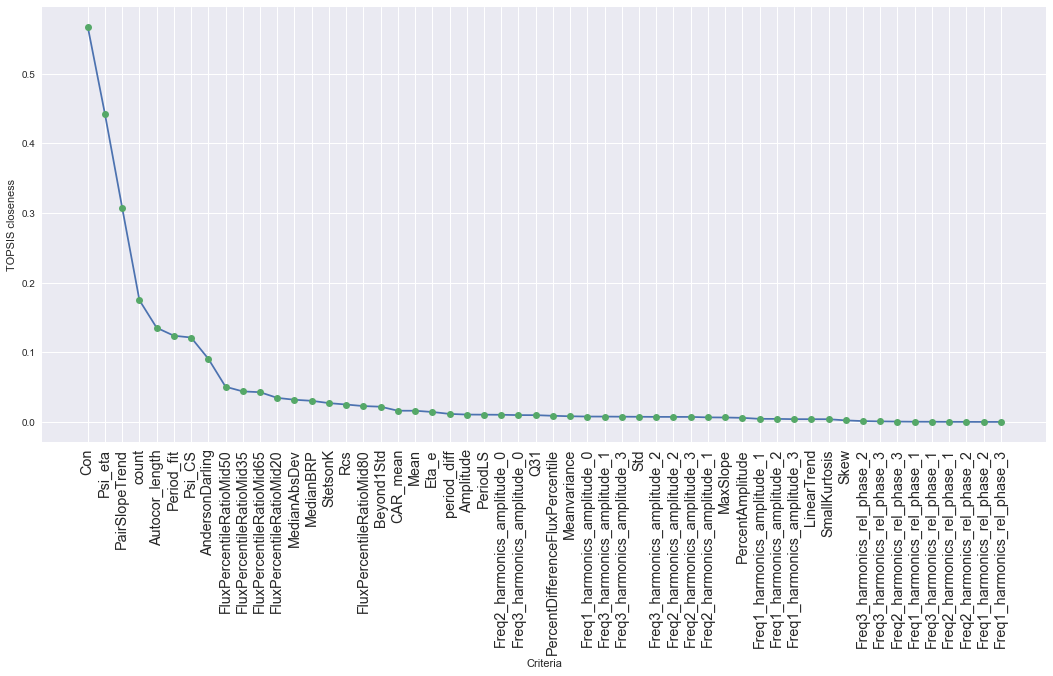

In [15]:
ax = plt.subplots(figsize=(18, 8))[-1]
ax.plot(closeness, "-")
ax.plot(closeness, "o")
ax.set_ylabel('TOPSIS closeness')
ax.set_xlabel("Criteria")

ax.set_xticks(ticks_range)
ax.set_xticklabels(X_order_col, rotation=90, size="large")
plt.show()